Benchmark: Accuracy 43%

## Histogram Boosting Gradient Classifier

In [1]:
# load Python packages
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import HistGradientBoostingClassifier
import pandas as pd
import numpy as np
import neurokit2 as nk
import matplotlib.pyplot as plt
from tqdm import tqdm
import xgboost
import shap

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load Maze Ball dataset
mb_data = pd.read_json("./mazeball.json")
mb_data = mb_data.mazeball.apply(pd.Series)
# data entries
mb_data.keys()

Index(['demographics', 'games', 'tutorial'], dtype='object')

In [3]:
# player demographics
# each entry contains demographic information for one player
p_demo = mb_data['demographics']
p_games = mb_data['games']
p_tutorial = mb_data['tutorial']
print("There are {} players in the dataset.".format(p_demo.shape))

There are (36,) players in the dataset.


In [4]:
# let's take the first player as an example
player_no = 1
print("Player information: ")
print(p_demo[player_no])

p_games = mb_data['games']
print("Number of sets of games played by this player is {}".format(
    np.shape(p_games[player_no])))

Player information: 
{'player_id': 2, 'age': 26, 'male': 1, 'playgames': 1, 'playgamesfrequency': 4}
Number of sets of games played by this player is (4,)


In [5]:
# let's take set 0 as an example
game_set_no = 0

# each entry contains game data and player preferences
p_games[player_no][game_set_no].keys()

dict_keys(['data', 'preferences'])

In [6]:
p_games_data = p_games[player_no][game_set_no]['data']
p_games_pref = p_games[player_no][game_set_no]['preferences']

print("Information in data: ", p_games_data.keys())
print("Information in pref: ", p_games_pref.keys())

Information in data:  dict_keys(['A', 'B'])
Information in pref:  dict_keys(['anxiety', 'challenge', 'excitement', 'boredom', 'frustration', 'relaxation', 'fun'])


In [7]:
def extract_sc(signal):
    df, info = nk.eda_process(signal, sampling_rate=31)

    features_sc = np.array([
        np.nanmean(info['SCR_Amplitude']),
        np.nanstd(info['SCR_Amplitude']),
        np.nanmean(info['SCR_RiseTime']),
        np.nanstd(info['SCR_RiseTime']),
        np.nanmean(info['SCR_RecoveryTime']),
        np.nanstd(info['SCR_RecoveryTime'])
    ])

    feature_sc_names = [
        'SCR_Amplitude_mean',
        'SCR_Amplitude_std',
        'SCR_RiseTime_mean',
        'SCR_RiseTime_std',
        'SCR_RecoveryTime_mean',
        'SCR_RecoveryTime_std'
    ]

    return features_sc, feature_sc_names


def extract_bvp(signal):
    df, info = nk.ppg_process(
        p_games_data['A'][game_set_no]['physio']['BVP'], sampling_rate=31)
    feature_bvp = nk.ppg_intervalrelated(df, sampling_rate=31)
    feature_bvp_names = list(feature_bvp)

    return feature_bvp.to_numpy()[0], feature_bvp_names


def extract_keystrokes(keystrokes_data):
    keys_of_interest = ['leftpressed', 'uppressed',
                        'spacepressed', 'rightpressed', 'downpressed']
    keystrokes_features = [sum(keystrokes_data[key])
                           for key in keys_of_interest]
    features_keystrokes_names = [f"{key}_count" for key in keys_of_interest]

    return keystrokes_features, features_keystrokes_names

In [8]:

alldata = {
    # demographics
    'player_id': [],
    'player_age': [],
    'player_gender': [],
    'player_playgames': [],
    'player_playfrequency': [],

    # games
    'game_variant': [],
    #     'features_gameplay': [],
    'features_keystrokes': [],
    'features_sc': [],
    'features_bvp': [],

    'class': [],  # anxiety, challenge, excitement, boredom, frustration, relaxation, fun
}

for a in tqdm(range(36)):  # player number
    player_demographics = p_demo[a]  # player demographics
    player_game = p_games[a]
    player_tutorial = p_tutorial[a]

    for b in range(len(player_game)):  # game number
        game_pref = p_games[a][b]['preferences']
        game_a = p_games[a][b]['data']['A'][0]
        game_b = p_games[a][b]['data']['B']

        # # Game A gameplay features
        # print(game_a['gameplay'].keys()) # in 90 seconds, how many data samples?

        # # Game A keystroke features
        # print(game_a['keystrokes'].keys()) # in 90 seconds, how many data samples?

        # # Game A physiological features
        # print(game_a['physio'].keys()) # in 90 seconds, how many data samples?
        features_sc_a, features_sc_names = extract_sc(game_a['physio']['SC'])
        features_bvp_a, features_bvp_names = extract_bvp(
            game_a['physio']['BVP'])

        # Extract keystroke features
        features_keystrokes_a, features_keystrokes_names = extract_keystrokes(
            game_a['keystrokes'])

        # Game B physiological features
        features_sc_b, _ = extract_sc(game_b['physio']['SC'])
        features_bvp_b, _ = extract_bvp(game_b['physio']['BVP'])

        # Extract keystroke features
        features_keystrokes_b, _ = extract_keystrokes(game_b['keystrokes'])

        # which affective data to collect?
        c = "anxiety"

        # append information for Game A
        alldata['player_id'] += [player_demographics['player_id']]
        alldata['player_age'] += [player_demographics['age']]
        alldata['player_gender'] += [player_demographics['male']]
        alldata['player_playgames'] += [player_demographics['playgames']]
        alldata['player_playfrequency'] += [player_demographics['playgamesfrequency']]

        alldata['game_variant'] += [game_a['variant']]
        alldata['features_sc'] += [features_sc_a]
        alldata['features_bvp'] += [features_bvp_a]

        alldata['features_keystrokes'] += [features_keystrokes_a]

        # append information for Game B
        alldata['player_id'] += [player_demographics['player_id']]
        alldata['player_age'] += [player_demographics['age']]
        alldata['player_gender'] += [player_demographics['male']]
        alldata['player_playgames'] += [player_demographics['playgames']]
        alldata['player_playfrequency'] += [player_demographics['playgamesfrequency']]

        alldata['game_variant'] += [game_a['variant']]
        alldata['features_sc'] += [features_sc_b]
        alldata['features_bvp'] += [features_bvp_b]

        alldata['features_keystrokes'] += [features_keystrokes_b]

        # generate labels based on preference ranking
        if game_pref[c] == "A":  # if game A is more preferred than game B
            alldata['class'] += [1]  # class label for Game A
            alldata['class'] += [0]  # class label for Game B

        elif game_pref[c] == "B":  # if game B is more preferred
            alldata['class'] += [0]
            alldata['class'] += [1]

        elif game_pref[c] == "Both equally":
            alldata['class'] += [1]
            alldata['class'] += [1]

        elif game_pref[c] == "Neither":
            alldata['class'] += [0]
            alldata['class'] += [0]

        # print(alldata['class'])

100%|██████████| 36/36 [00:27<00:00,  1.29it/s]


In [9]:
# create dataset
X = []  # training data (features)
Y = []  # class label   (target)
Z = []  # player id for cross-validation
for i in range(len(alldata['class'])):
    vec = np.concatenate([
        np.array([alldata['player_age'][i],
                  alldata['player_gender'][i],
                  alldata['player_playgames'][i],
                  alldata['player_playfrequency'][i],
                  alldata['game_variant'][i]
                  ]),
        alldata['features_sc'][i],
        alldata['features_bvp'][i],
        alldata['features_keystrokes'][i],
    ])
    X += [vec.astype(float)]
    Y += [alldata['class'][i]]
    Z += [alldata['player_id'][i]]

feature_names = []
feature_names += ['player_age']
feature_names += ['player_gender']
feature_names += ['player_playgames']
feature_names += ['player_playfrequency']
feature_names += ['game_variant']
feature_names += features_sc_names
feature_names += features_bvp_names
feature_names += features_keystrokes_names

X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)
player_id = np.unique(Z)

### Data Cleaning

In [10]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df = pd.DataFrame(data=X, columns=feature_names)
df[c] = Y
print(df.shape)
df.head()

(288, 100)


,player_age,player_gender,player_playgames,player_playfrequency,game_variant,SCR_Amplitude_mean,SCR_Amplitude_std,SCR_RiseTime_mean,SCR_RiseTime_std,SCR_RecoveryTime_mean,SCR_RecoveryTime_std,PPG_Rate_Mean,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,HRV_CVNN,HRV_CVSD,HRV_MedianNN,HRV_MadNN,HRV_MCVNN,HRV_IQRNN,HRV_SDRMSSD,HRV_Prc20NN,HRV_Prc80NN,HRV_pNN50,HRV_pNN20,HRV_MinNN,HRV_MaxNN,HRV_HTI,HRV_TINN,HRV_ULF,HRV_VLF,HRV_LF,HRV_HF,HRV_VHF,HRV_TP,HRV_LFHF,HRV_LFn,HRV_HFn,HRV_LnHF,HRV_SD1,HRV_SD2,HRV_SD1SD2,HRV_S,HRV_CSI,HRV_CVI,HRV_CSI_Modified,HRV_PIP,HRV_IALS,HRV_PSS,HRV_PAS,HRV_GI,HRV_SI,HRV_AI,HRV_PI,HRV_C1d,HRV_C1a,HRV_SD1d,HRV_SD1a,HRV_C2d,HRV_C2a,HRV_SD2d,HRV_SD2a,HRV_Cd,HRV_Ca,HRV_SDNNd,HRV_SDNNa,HRV_DFA_alpha1,HRV_MFDFA_alpha1_Width,HRV_MFDFA_alpha1_Peak,HRV_MFDFA_alpha1_Mean,HRV_MFDFA_alpha1_Max,HRV_MFDFA_alpha1_Delta,HRV_MFDFA_alpha1_Asymmetry,HRV_MFDFA_alpha1_Fluctuation,HRV_MFDFA_alpha1_Increment,HRV_ApEn,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC,leftpressed_count,uppressed_count,spacepressed_count,rightpressed_count,downpressed_count,anxiety
0,26.0,1.0,1.0,5.0,1.0,0.358530,0.312950,0.859583,0.406223,0.491935,0.360205,61.229719,980.645161,58.589707,NaN,NaN,NaN,NaN,NaN,NaN,72.937186,73.349525,0.059746,0.074377,1000.0,47.825806,0.047826,96.774194,0.80329,935.483871,1032.258065,48.888889,83.333333,838.709677,1096.774194,3.6,164.0625,NaN,NaN,0.011161,0.048783,0.002586,0.062531,0.228797,0.178496,0.780148,-3.020368,51.865947,65.170778,0.795847,10619.035879,1.256523,4.733055,327.554445,0.755556,0.76,1.0,0.285714,49.689441,49.696817,49.683931,46.666667,0.483516,0.516484,36.065613,37.27485,0.532394,0.467606,47.552092,44.564884,0.513441,0.486559,42.20148,41.081889,0.520401,0.795305,0.607206,0.893675,-0.140908,-1.092152,-0.1398,0.000308,0.048143,0.767695,1.731656,2.774938,1.583665,1.277666,1.253381,1.651794,0.842629,2.009294,4.415038,0.577054,21.0,0.0,0.0,27.0,18.0,0
1,26.0,1.0,1.0,5.0,1.0,0.665741,0.404745,1.136364,0.427391,0.697389,0.343626,61.229719,980.645161,58.589707,NaN,NaN,NaN,NaN,NaN,NaN,72.937186,73.349525,0.059746,0.074377,1000.0,47.825806,0.047826,96.774194,0.80329,935.483871,1032.258065,48.888889,83.333333,838.709677,1096.774194,3.6,164.0625,NaN,NaN,0.011161,0.048783,0.002586,0.062531,0.228797,0.178496,0.780148,-3.020368,51.865947,65.170778,0.795847,10619.035879,1.256523,4.733055,327.554445,0.755556,0.76,1.0,0.285714,49.689441,49.696817,49.683931,46.666667,0.483516,0.516484,36.065613,37.27485,0.532394,0.467606,47.552092,44.564884,0.513441,0.486559,42.20148,41.081889,0.520401,0.795305,0.607206,0.893675,-0.140908,-1.092152,-0.1398,0.000308,0.048143,0.767695,1.731656,2.774938,1.583665,1.277666,1.253381,1.651794,0.842629,2.009294,4.415038,0.577054,26.0,1.0,0.0,21.0,16.0,1
2,26.0,1.0,1.0,5.0,8.0,0.918398,0.823357,1.479263,0.760327,1.142857,0.994538,61.229719,980.645161,58.589707,NaN,NaN,NaN,NaN,NaN,NaN,72.937186,73.349525,0.059746,0.074377,1000.0,47.825806,0.047826,96.774194,0.80329,935.483871,1032.258065,48.888889,83.333333,838.709677,1096.774194,3.6,164.0625,NaN,NaN,0.011161,0.048783,0.002586,0.062531,0.228797,0.178496,0.780148,-3.020368,51.865947,65.170778,0.795847,10619.035879,1.256523,4.733055,327.554445,0.755556,0.76,1.0,0.285714,49.689441,49.696817,49.683931,46.666667,0.483516,0.516484,36.065613,37.27485,0.532394,0.467606,47.552092,44.564884,0.513441,0.486559,42.20148,41.081889,0.520401,0.795305,0.607206,0.893675,-0.140908,-1.092152,-0.1398,0.000308,0.048143,0.767695,1.731656,2.774938,1.583665,1.277666,1.253381,1.651794,0.842629,2.009294,4.415038,0.577054,17.0,6.0,5.0,17.0,14.0,1
3,26.0,1.0,1.0,5.0,8.0,0.448668,0.665879,1.115207,0.649034,1.396313,0.858801,61.229719,980.645161,58.589707,NaN,NaN,NaN,NaN,NaN,NaN,72.937186,73.349525,0.059746,0.074377,1000.0,47.825806,0.047826,96.774194,0.80329,935.483871,1032.258065,48.888889,83.333333,838.709677,1096.774194,3.6,164.0625,NaN,NaN,0.011161,0.048783,0.00258

In [11]:
# Check for columns with missing vals
missing_vals_cols = df.isna().sum()
missing_vals_cols[missing_vals_cols > 0]

SCR_Amplitude_mean         1
SCR_Amplitude_std          1
SCR_RiseTime_mean          1
SCR_RiseTime_std           1
SCR_RecoveryTime_mean      1
SCR_RecoveryTime_std       1
HRV_SDANN1               288
HRV_SDNNI1               288
HRV_SDANN2               288
HRV_SDNNI2               288
HRV_SDANN5               288
HRV_SDNNI5               288
HRV_ULF                  288
HRV_VLF                  288
dtype: int64

In [12]:
# Check the row with missing values on the column that has 1 missing val
df[df['SCR_Amplitude_mean'].isna()]

,player_age,player_gender,player_playgames,player_playfrequency,game_variant,SCR_Amplitude_mean,SCR_Amplitude_std,SCR_RiseTime_mean,SCR_RiseTime_std,SCR_RecoveryTime_mean,SCR_RecoveryTime_std,PPG_Rate_Mean,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,HRV_CVNN,HRV_CVSD,HRV_MedianNN,HRV_MadNN,HRV_MCVNN,HRV_IQRNN,HRV_SDRMSSD,HRV_Prc20NN,HRV_Prc80NN,HRV_pNN50,HRV_pNN20,HRV_MinNN,HRV_MaxNN,HRV_HTI,HRV_TINN,HRV_ULF,HRV_VLF,HRV_LF,HRV_HF,HRV_VHF,HRV_TP,HRV_LFHF,HRV_LFn,HRV_HFn,HRV_LnHF,HRV_SD1,HRV_SD2,HRV_SD1SD2,HRV_S,HRV_CSI,HRV_CVI,HRV_CSI_Modified,HRV_PIP,HRV_IALS,HRV_PSS,HRV_PAS,HRV_GI,HRV_SI,HRV_AI,HRV_PI,HRV_C1d,HRV_C1a,HRV_SD1d,HRV_SD1a,HRV_C2d,HRV_C2a,HRV_SD2d,HRV_SD2a,HRV_Cd,HRV_Ca,HRV_SDNNd,HRV_SDNNa,HRV_DFA_alpha1,HRV_MFDFA_alpha1_Width,HRV_MFDFA_alpha1_Peak,HRV_MFDFA_alpha1_Mean,HRV_MFDFA_alpha1_Max,HRV_MFDFA_alpha1_Delta,HRV_MFDFA_alpha1_Asymmetry,HRV_MFDFA_alpha1_Fluctuation,HRV_MFDFA_alpha1_Increment,HRV_ApEn,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC,leftpressed_count,uppressed_count,spacepressed_count,rightpressed_count,downpressed_count,anxiety
72,29.0,1.0,1.0,5.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,61.229719,980.645161,58.589707,NaN,NaN,NaN,NaN,NaN,NaN,72.937186,73.349525,0.059746,0.074377,1000.0,47.825806,0.047826,96.774194,0.80329,935.483871,1032.258065,48.888889,83.333333,838.709677,1096.774194,3.6,164.0625,NaN,NaN,0.011161,0.048783,0.002586,0.062531,0.228797,0.178496,0.780148,-3.020368,51.865947,65.170778,0.795847,10619.035879,1.256523,4.733055,327.554445,0.755556,0.76,1.0,0.285714,49.689441,49.696817,49.683931,46.666667,0.483516,0.516484,36.065613,37.27485,0.532394,0.467606,47.552092,44.564884,0.513441,0.486559,42.20148,41.081889,0.520401,0.795305,0.607206,0.893675,-0.140908,-1.092152,-0.1398,0.000308,0.048143,0.767695,1.731656,2.774938,1.583665,1.277666,1.253381,1.651794,0.842629,2.009294,4.415038,0.577054,28.0,0.0,0.0,29.0,7.0,0


In [13]:
# Fill up the missing values on row 72
cols_2_fill = ['SCR_Amplitude_mean', 'SCR_Amplitude_std', 'SCR_RiseTime_mean', 'SCR_RiseTime_std', 'SCR_RecoveryTime_mean', 'SCR_RecoveryTime_std']
df.loc[72, cols_2_fill] = df.mean()
print("Values filled: ")
df.loc[72, cols_2_fill]

Values filled: 


SCR_Amplitude_mean       0.370727
SCR_Amplitude_std        0.305722
SCR_RiseTime_mean        1.183024
SCR_RiseTime_std         0.720504
SCR_RecoveryTime_mean    1.242509
SCR_RecoveryTime_std     1.091095
Name: 72, dtype: float64

In [14]:
# Drop the columns with missing vals in all rows
try:
    df.drop(columns=[
            'HRV_SDANN1', 'HRV_SDNNI1', 'HRV_SDANN2',
            'HRV_SDNNI2', 'HRV_SDANN5', 'HRV_SDNNI5',
            'HRV_ULF', 'HRV_VLF'
            ], inplace=True)
except KeyError:
    print("Columns Dropped!")

In [15]:
print(f"Dim: {df.shape}")
df.head()

Dim: (288, 92)


,player_age,player_gender,player_playgames,player_playfrequency,game_variant,SCR_Amplitude_mean,SCR_Amplitude_std,SCR_RiseTime_mean,SCR_RiseTime_std,SCR_RecoveryTime_mean,SCR_RecoveryTime_std,PPG_Rate_Mean,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_SDSD,HRV_CVNN,HRV_CVSD,HRV_MedianNN,HRV_MadNN,HRV_MCVNN,HRV_IQRNN,HRV_SDRMSSD,HRV_Prc20NN,HRV_Prc80NN,HRV_pNN50,HRV_pNN20,HRV_MinNN,HRV_MaxNN,HRV_HTI,HRV_TINN,HRV_LF,HRV_HF,HRV_VHF,HRV_TP,HRV_LFHF,HRV_LFn,HRV_HFn,HRV_LnHF,HRV_SD1,HRV_SD2,HRV_SD1SD2,HRV_S,HRV_CSI,HRV_CVI,HRV_CSI_Modified,HRV_PIP,HRV_IALS,HRV_PSS,HRV_PAS,HRV_GI,HRV_SI,HRV_AI,HRV_PI,HRV_C1d,HRV_C1a,HRV_SD1d,HRV_SD1a,HRV_C2d,HRV_C2a,HRV_SD2d,HRV_SD2a,HRV_Cd,HRV_Ca,HRV_SDNNd,HRV_SDNNa,HRV_DFA_alpha1,HRV_MFDFA_alpha1_Width,HRV_MFDFA_alpha1_Peak,HRV_MFDFA_alpha1_Mean,HRV_MFDFA_alpha1_Max,HRV_MFDFA_alpha1_Delta,HRV_MFDFA_alpha1_Asymmetry,HRV_MFDFA_alpha1_Fluctuation,HRV_MFDFA_alpha1_Increment,HRV_ApEn,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC,leftpressed_count,uppressed_count,spacepressed_count,rightpressed_count,downpressed_count,anxiety
0,26.0,1.0,1.0,5.0,1.0,0.358530,0.312950,0.859583,0.406223,0.491935,0.360205,61.229719,980.645161,58.589707,72.937186,73.349525,0.059746,0.074377,1000.0,47.825806,0.047826,96.774194,0.80329,935.483871,1032.258065,48.888889,83.333333,838.709677,1096.774194,3.6,164.0625,0.011161,0.048783,0.002586,0.062531,0.228797,0.178496,0.780148,-3.020368,51.865947,65.170778,0.795847,10619.035879,1.256523,4.733055,327.554445,0.755556,0.76,1.0,0.285714,49.689441,49.696817,49.683931,46.666667,0.483516,0.516484,36.065613,37.27485,0.532394,0.467606,47.552092,44.564884,0.513441,0.486559,42.20148,41.081889,0.520401,0.795305,0.607206,0.893675,-0.140908,-1.092152,-0.1398,0.000308,0.048143,0.767695,1.731656,2.774938,1.583665,1.277666,1.253381,1.651794,0.842629,2.009294,4.415038,0.577054,21.0,0.0,0.0,27.0,18.0,0
1,26.0,1.0,1.0,5.0,1.0,0.665741,0.404745,1.136364,0.427391,0.697389,0.343626,61.229719,980.645161,58.589707,72.937186,73.349525,0.059746,0.074377,1000.0,47.825806,0.047826,96.774194,0.80329,935.483871,1032.258065,48.888889,83.333333,838.709677,1096.774194,3.6,164.0625,0.011161,0.048783,0.002586,0.062531,0.228797,0.178496,0.780148,-3.020368,51.865947,65.170778,0.795847,10619.035879,1.256523,4.733055,327.554445,0.755556,0.76,1.0,0.285714,49.689441,49.696817,49.683931,46.666667,0.483516,0.516484,36.065613,37.27485,0.532394,0.467606,47.552092,44.564884,0.513441,0.486559,42.20148,41.081889,0.520401,0.795305,0.607206,0.893675,-0.140908,-1.092152,-0.1398,0.000308,0.048143,0.767695,1.731656,2.774938,1.583665,1.277666,1.253381,1.651794,0.842629,2.009294,4.415038,0.577054,26.0,1.0,0.0,21.0,16.0,1
2,26.0,1.0,1.0,5.0,8.0,0.918398,0.823357,1.479263,0.760327,1.142857,0.994538,61.229719,980.645161,58.589707,72.937186,73.349525,0.059746,0.074377,1000.0,47.825806,0.047826,96.774194,0.80329,935.483871,1032.258065,48.888889,83.333333,838.709677,1096.774194,3.6,164.0625,0.011161,0.048783,0.002586,0.062531,0.228797,0.178496,0.780148,-3.020368,51.865947,65.170778,0.795847,10619.035879,1.256523,4.733055,327.554445,0.755556,0.76,1.0,0.285714,49.689441,49.696817,49.683931,46.666667,0.483516,0.516484,36.065613,37.27485,0.532394,0.467606,47.552092,44.564884,0.513441,0.486559,42.20148,41.081889,0.520401,0.795305,0.607206,0.893675,-0.140908,-1.092152,-0.1398,0.000308,0.048143,0.767695,1.731656,2.774938,1.583665,1.277666,1.253381,1.651794,0.842629,2.009294,4.415038,0.577054,17.0,6.0,5.0,17.0,14.0,1
3,26.0,1.0,1.0,5.0,8.0,0.448668,0.665879,1.115207,0.649034,1.396313,0.858801,61.229719,980.645161,58.589707,72.937186,73.349525,0.059746,0.074377,1000.0,47.825806,0.047826,96.774194,0.80329,935.483871,1032.258065,48.888889,83.333333,838.709677,1096.774194,3.6,164.0625,0.011161,0.048783,0.002586,0.062531,0.228797,0.178496,0.780148,-3.020368,51.865947,65.170778,0.795847,10619.035879,1.256523,4.733055,327.554445,0.755556,0.76,1.0,0.285714,49.689441,49.696817,49.683931,46.666667,0.483516,0.516484,36.065

In [16]:
X_cleaned = df.iloc[:, :-1].values
feature_names_cleaned = df.iloc[:, :-1].columns
Y_cleaned = df.iloc[:, -1].values

In [17]:
def pred_model1(X, Y, Z):
    # Initialize lists to store predictions and labels
    predictions_histgb = []
    labels_histgb = []

    # Perform leave-one-person-out cross-validation
    for idx in player_id:
        istrain = Z != idx
        istest = Z == idx

        X_train = X[istrain]
        X_test = X[istest]
        Y_train = Y[istrain]
        Y_test = Y[istest]

        # Create a new HistGradientBoostingClassifier for each cross-validation iteration
        model_histgb = HistGradientBoostingClassifier(
            random_state=42)  # You can adjust the parameters
        model_histgb.fit(X_train, Y_train)

        # Test the model
        Y_predicted_histgb = model_histgb.predict(X_test)

        # Store predictions and true labels
        predictions_histgb += [Y_predicted_histgb]
        labels_histgb += [Y_test]

    # Calculate accuracy
    accuracy_histgb = accuracy_score(np.concatenate(
        labels_histgb), np.concatenate(predictions_histgb))
    print("HistGradientBoostingClassifier Accuracy:", accuracy_histgb)
    return model_histgb

In [18]:
model_histgb = pred_model1(X_cleaned, Y_cleaned, Z)

HistGradientBoostingClassifier Accuracy: 0.4756944444444444


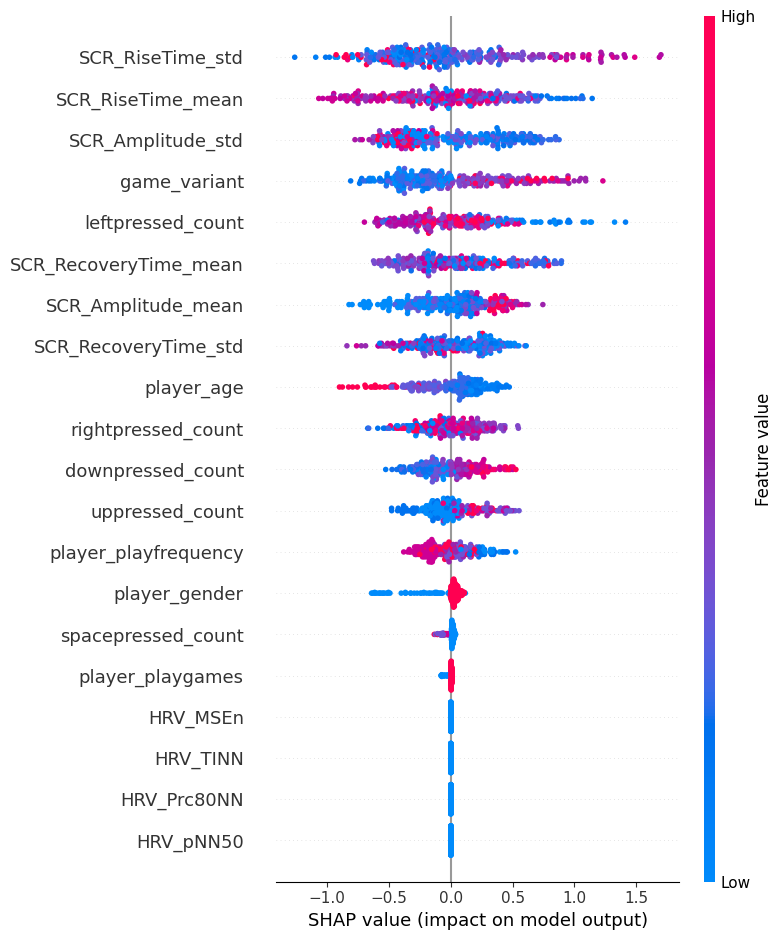

In [19]:
# Create a SHAP explainer for the trained model
explainer = shap.TreeExplainer(model_histgb)

# Calculate SHAP values for the entire dataset
shap_values = explainer.shap_values(X_cleaned)

# Display the summary plot
# Provide feature names if available
shap.summary_plot(shap_values, X_cleaned, feature_names=feature_names_cleaned)

In [20]:
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

# Create a DataFrame to store feature names and mean absolute SHAP values
feature_importance = pd.DataFrame({'Feature': feature_names_cleaned, 'MeanAbsShap': mean_abs_shap_values})

# Sort the DataFrame by mean absolute SHAP values in descending order
f_imp_df = feature_importance.sort_values(by='MeanAbsShap', ascending=False)
list(f_imp_df[f_imp_df['MeanAbsShap'] > 0.05]['Feature'])

['SCR_RiseTime_std',
 'SCR_RiseTime_mean',
 'SCR_Amplitude_std',
 'game_variant',
 'leftpressed_count',
 'SCR_RecoveryTime_mean',
 'SCR_Amplitude_mean',
 'SCR_RecoveryTime_std',
 'player_age',
 'rightpressed_count',
 'downpressed_count',
 'uppressed_count',
 'player_playfrequency',
 'player_gender']

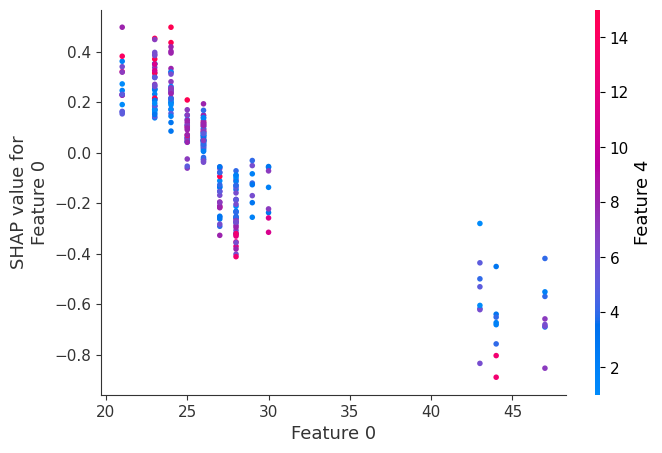

In [16]:
shap.dependence_plot(0, shap_values, X)

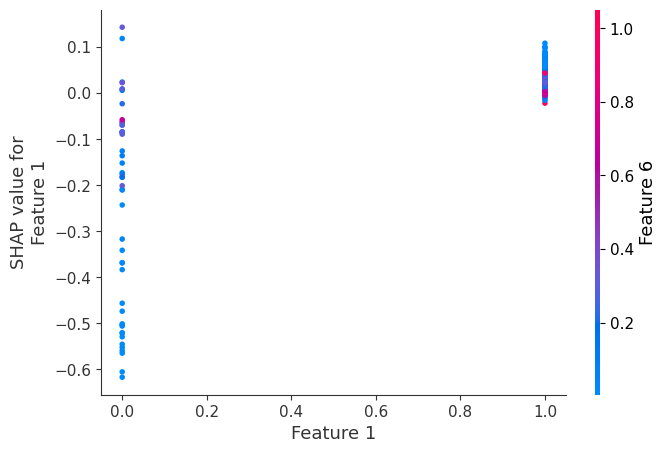

In [14]:
shap.dependence_plot(1, shap_values, X)

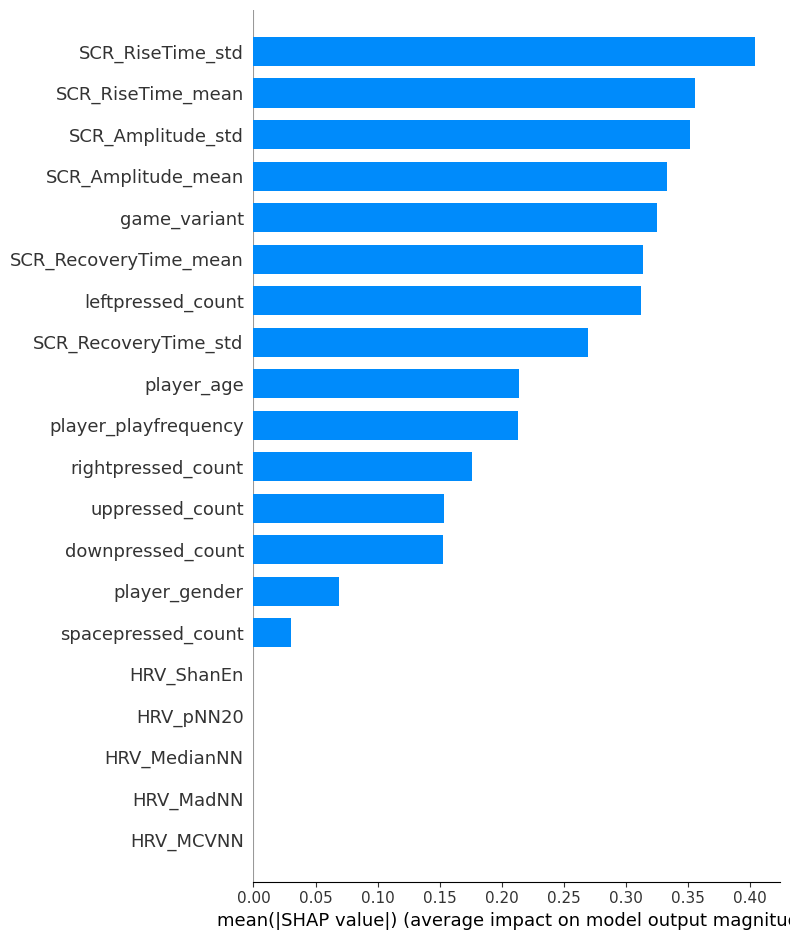

In [15]:
shap.summary_plot(shap_values, X, plot_type="bar", feature_names=feature_names)

## Support Vector Machines (SVM)

In [1]:
from sklearn.svm import SVC

In [3]:
# load Maze Ball dataset
mb_data = pd.read_json("./mazeball.json")
mb_data = mb_data.mazeball.apply(pd.Series)
# data entries
mb_data.keys()

Index(['demographics', 'games', 'tutorial'], dtype='object')

In [4]:
# player demographics
# each entry contains demographic information for one player
p_demo = mb_data['demographics']
p_games = mb_data['games']
p_tutorial = mb_data['tutorial']
print("There are {} players in the dataset.".format(p_demo.shape))

There are (36,) players in the dataset.


In [5]:
# let's take the first player as an example
player_no = 1
print("Player information: ")
print(p_demo[player_no])

p_games = mb_data['games']
print("Number of sets of games played by this player is {}".format(
    np.shape(p_games[player_no])))

Player information: 
{'player_id': 2, 'age': 26, 'male': 1, 'playgames': 1, 'playgamesfrequency': 4}
Number of sets of games played by this player is (4,)


In [6]:
# let's take set 0 as an example
game_set_no = 0

# each entry contains game data and player preferences
p_games[player_no][game_set_no].keys()

dict_keys(['data', 'preferences'])

In [17]:
p_games_data = p_games[player_no][game_set_no]['data']
p_games_pref = p_games[player_no][game_set_no]['preferences']

print("Information in data: ", p_games_data.keys())
print("Information in pref: ", p_games_pref.keys())

Information in data:  dict_keys(['A', 'B'])
Information in pref:  dict_keys(['anxiety', 'challenge', 'excitement', 'boredom', 'frustration', 'relaxation', 'fun'])


In [19]:
def extract_gameplay_features(gameplay_data):
    # Extract relevant features from gameplay data
    score = gameplay_data['score']
    time = gameplay_data['time']
    distance_to_enemies_euclidean = gameplay_data['distance2enemies_euclidean']
    distance_to_pellets_euclidean = gameplay_data['distance2pellets_euclidean']
    tile_visits = gameplay_data['tilevisits']
    # Assuming 'event' is a relevant feature for challenge
    events = gameplay_data['event']

    # Concatenate all features into a single feature vector
    feature_vector = [score, time, distance_to_enemies_euclidean,
                      distance_to_pellets_euclidean, tile_visits]

    # Define the names of the features
    feature_names = [
        'score',
        'time',
        'distance_to_enemies_euclidean',
        'distance_to_pellets_euclidean',
        'tile_visits'
    ]

    return feature_vector, feature_names


def extract_keystrokes(keystrokes_data):
    keys_of_interest = ['leftpressed', 'uppressed',
                        'spacepressed', 'rightpressed', 'downpressed']
    keystrokes_features = [sum(keystrokes_data[key])
                           for key in keys_of_interest]
    features_keystrokes_names = [f"{key}_count" for key in keys_of_interest]

    return keystrokes_features, features_keystrokes_names

In [20]:

alldata = {
    # demographics
    'player_id': [],
    'player_age': [],
    'player_gender': [],
    'player_playgames': [],
    'player_playfrequency': [],

    # games
    'game_variant': [],
    'features_gameplay': [],
    'features_keystrokes': [],

    'class': [],  # anxiety, challenge, excitement, boredom, frustration, relaxation, fun
}

for a in tqdm(range(36)):  # player number
    player_demographics = p_demo[a]  # player demographics
    player_game = p_games[a]
    player_tutorial = p_tutorial[a]

    for b in range(len(player_game)):  # game number
        game_pref = p_games[a][b]['preferences']
        game_a = p_games[a][b]['data']['A'][0]
        game_b = p_games[a][b]['data']['B']

        # # Game A gameplay features
        # print(game_a['gameplay'].keys()) # in 90 seconds, how many data samples?

        # # Game A keystroke features
        # print(game_a['keystrokes'].keys()) # in 90 seconds, how many data samples?

        #
        # print(game_a['physio'].keys()) # in 90 seconds, how many data samples?

        # Game A gameplay features
        features_gameplay_a, features_gameplay_names = extract_gameplay_features(
            game_a['gameplay'])

        # Extract keystroke features
        features_keystrokes_a, features_keystrokes_names = extract_keystrokes(
            game_a['keystrokes'])

        # Game B gameplay features
        features_gameplay_b, _ = extract_gameplay_features(game_b['gameplay'])

        # Extract keystroke features
        features_keystrokes_b, _ = extract_keystrokes(game_b['keystrokes'])

        # which affective data to collect?
        c = "challenge"

        # append information for Game A
        alldata['player_id'] += [player_demographics['player_id']]
        alldata['player_age'] += [player_demographics['age']]
        alldata['player_gender'] += [player_demographics['male']]
        alldata['player_playgames'] += [player_demographics['playgames']]
        alldata['player_playfrequency'] += [player_demographics['playgamesfrequency']]

        alldata['game_variant'] += [game_a['variant']]
        alldata['features_gameplay'] += [features_keystrokes_a]
        alldata['features_keystrokes'] += [features_keystrokes_a]

        # append information for Game B
        alldata['player_id'] += [player_demographics['player_id']]
        alldata['player_age'] += [player_demographics['age']]
        alldata['player_gender'] += [player_demographics['male']]
        alldata['player_playgames'] += [player_demographics['playgames']]
        alldata['player_playfrequency'] += [player_demographics['playgamesfrequency']]

        alldata['game_variant'] += [game_a['variant']]
        alldata['features_gameplay'] += [features_keystrokes_b]
        alldata['features_keystrokes'] += [features_keystrokes_b]

        # generate labels based on preference ranking
        if game_pref[c] == "A":  # if game A is more preferred than game B
            alldata['class'] += [1]  # class label for Game A
            alldata['class'] += [0]  # class label for Game B

        elif game_pref[c] == "B":  # if game B is more preferred
            alldata['class'] += [0]
            alldata['class'] += [1]

        elif game_pref[c] == "Both equally":
            alldata['class'] += [1]
            alldata['class'] += [1]

        elif game_pref[c] == "Neither":
            alldata['class'] += [0]
            alldata['class'] += [0]

        # print(alldata['class'])

100%|██████████| 36/36 [00:00<00:00, 9005.48it/s]


In [21]:

# create dataset
X = []  # training data
Y = []  # class label
Z = []  # player id for cross-validation
for i in range(len(alldata['class'])):
    vec = np.concatenate([
        np.array([alldata['player_age'][i],
                  alldata['player_gender'][i],
                  alldata['player_playgames'][i],
                  alldata['player_playfrequency'][i],
                  alldata['game_variant'][i]
                  ]),
        alldata['features_gameplay'][i],
        alldata['features_keystrokes'][i],
    ])
    X += [vec.astype(float)]
    Y += [alldata['class'][i]]
    Z += [alldata['player_id'][i]]

feature_names = []
feature_names += ['player_age']
feature_names += ['player_gender']
feature_names += ['player_playgames']
feature_names += ['player_playfrequency']
feature_names += ['game_variant']
feature_names += features_gameplay_names
feature_names += features_keystrokes_names

X = np.array(X)
# X = np.nan_to_num(X, nan=np.nanmean(X))
Y = np.array(Y)
Z = np.array(Z)
player_id = np.unique(Z)

In [22]:

# Initialize lists to store predictions and labels
predictions_svm = []
labels_svm = []


# Perform leave-one-person-out cross-validation using SVM
for idx in player_id:
    istrain = Z != idx
    istest = Z == idx

    X_train = X[istrain]
    X_test = X[istest]
    Y_train = Y[istrain]
    Y_test = Y[istest]

    # Create a new SVM model for each cross-validation iteration
    # You can adjust the kernel and other parameters
    model_svm = SVC(kernel='linear')
    model_svm.fit(X_train, Y_train)

    # Test the model
    Y_predicted_svm = model_svm.predict(X_test)

    # Store predictions and true labels
    predictions_svm += [Y_predicted_svm]
    labels_svm += [Y_test]

# Calculate accuracy for SVM
accuracy_svm = np.mean(np.concatenate(predictions_svm)
                       == np.concatenate(labels_svm))
print("SVM Accuracy:", accuracy_svm)

SVM Accuracy: 0.5486111111111112


In [27]:
# Positive coefficients indicate a positive contribution to the prediction,
# while negative coefficients indicate a negative contribution.
coefficients = model_svm.coef_.flatten()
print(coefficients)

[-7.42086273e-07  7.31237552e-04 -9.83799430e-04 -3.50808242e-05
 -8.93141101e-06  5.84740335e-06 -1.07407445e-05 -1.99984241e-01
 -7.27513781e-07 -2.79338002e-06  5.84740335e-06 -1.07407445e-05
 -1.99984241e-01 -7.27512988e-07 -2.79337990e-06]


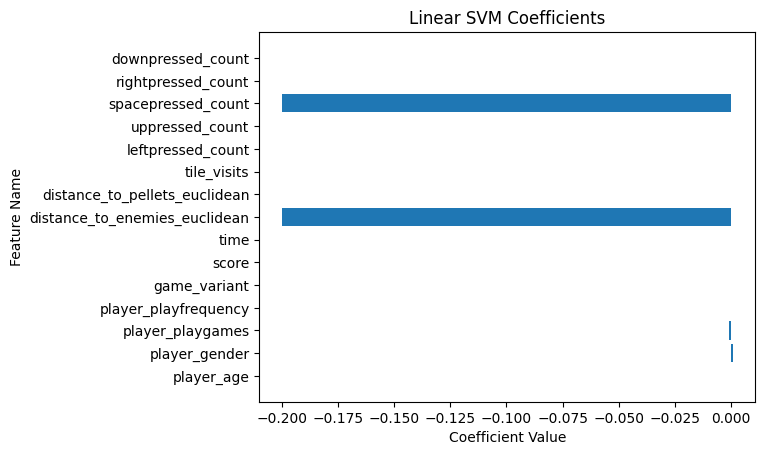

In [25]:
# Get the coefficients and feature names
coefficients = model_svm.coef_.flatten()

# Plot the coefficients
plt.barh(feature_names, coefficients)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.title('Linear SVM Coefficients')
plt.show()